<a href="https://colab.research.google.com/github/nyp-sit/iti121-2025s2/blob/main/L6/yolo_custom_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ITI121 Assignment 2: Custom Object Detection with YOLOv11
## Overview
This notebook demonstrates the end-to-end process of training, optimizing, and deploying a custom object detection model. The goal is to accurately detect Paint Brushes and Paint Palettes using the Ultralytics YOLOv11 architecture.

## Key Steps & Experiments
## Data Preparation:

Loading a custom annotated dataset (approx. 150+ images) from Google Drive.

Configuring data.yaml for custom classes.

## Model Training (Baseline):

Fine-tuning the pre-trained YOLOv11s (Small) model.

Integration with Weights & Biases (W&B) for real-time experiment tracking.

## xperimentation & Optimization:

Experiment A (Architecture): Comparing performance against the lightweight YOLOv11n (Nano) model.

Experiment B (Augmentation): Stress-testing with high rotation and scaling to evaluate robustness.

Experiment C (Hyperparameters): Switching the optimizer to SGD to improve convergence and precision.

## Evaluation:

Analyzing Mean Average Precision (mAP) across all experiments to select the best model.

Visualizing predictions on test images and videos.

## Deployment Preparation:

Exporting the best model to OpenVINO format for optimized inference.

Saving the final weights (best.pt) for deployment to a Hugging Face Space.

### Load Annotated Dataset




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install ultralytics

In [4]:
%%capture
%%bash

# 1. Create the destination directory
mkdir -p datasets/assignment2

# 2. Copy the zip file from your Google Drive to the local Colab machine
# (This is faster than unzipping directly from Drive)
cp "/content/drive/My Drive/ITI121_Assignment2/assignment2.v1i.yolov11.zip" .

# 3. Unzip into the datasets folder
unzip -o assignment2.v1i.yolov11.zip -d datasets/assignment2

In [5]:
from ultralytics import settings

settings.update({"wandb": True,
                 "clearml": False,
                 "comet": False})

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
!ls -la datasets/assignment2/train/images | wc -l

157


### Format the path


In [13]:
import os
import yaml

# 1. Define where we are looking
base_dir = os.path.abspath("datasets/assignment2")

print(f"🔍 Searching for image folders inside: {base_dir} ...")

# 2. Walk through the directory to find where images actually are
found_train = None
found_val = None

for root, dirs, files in os.walk(base_dir):
    # Check if this folder contains images
    if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in files):
        path = os.path.abspath(root)

        # Identify if it is a train or validation folder
        if "train" in path:
            found_train = path
        elif "valid" in path or "val" in path:
            found_val = path

# 3. Handle cases where Validation set might be missing
if found_train and not found_val:
    print("⚠️ Warning: Could not find a 'valid' folder. Using 'train' folder for validation to prevent errors.")
    found_val = found_train

# 4. If we found the folders, rewrite the data.yaml
if found_train and found_val:
    print(f"✅ Found Train Images at: {found_train}")
    print(f"✅ Found Valid Images at: {found_val}")

    # Create the correct configuration
    new_config = {
        'path': base_dir,
        'train': found_train,
        'val': found_val,
        'test': found_val, # Optional fallback
        'names': {
            0: 'paint brush',
            1: 'paint palette'
        }
    }

    # Overwrite the file
    yaml_path = os.path.join(base_dir, "data.yaml")
    with open(yaml_path, 'w') as f:
        yaml.dump(new_config, f)

    print(f"\n🎉 Success! 'data.yaml' has been updated.")
    print("You can now run the training cell again.")

else:
    print("\n❌ Error: Could not find any image folders in datasets/assignment2.")
    print("Did you remember to run the 'Unzip Dataset' step after restarting the runtime?")
    print("Current contents of datasets folder:")
    !ls -R datasets

🔍 Searching for image folders inside: /content/datasets/assignment2 ...
⚠️ Warning: Could not find a 'valid' folder. Using 'train' folder for validation to prevent errors.
✅ Found Train Images at: /content/datasets/assignment2/train/images
✅ Found Valid Images at: /content/datasets/assignment2/train/images

🎉 Success! 'data.yaml' has been updated.
You can now run the training cell again.


## Training with YOLOv11s

In [14]:
from ultralytics import YOLO
from ultralytics import settings

model = YOLO("yolo11s.pt")  # Load a pre-trained YOLO model
result = model.train(data="datasets/assignment2/data.yaml",
                     epochs=30,
                     save_period=1,
                     batch=64,
                     device=0,
                     project='assignment2_project',
                     plots=True)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/assignment2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=1

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: simlarry (simlarry-nyp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

wandb: WARNING Tried to log to step 30 that is less than the current step 31. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


lr/pg0,▁▂▃▄▄▅▆▆▇▇▇████████▇▇▇▆▆▅▅▄▃▂▂
lr/pg1,▁▂▃▄▄▅▆▆▇▇▇████████▇▇▇▆▆▅▅▄▃▂▂
lr/pg2,▁▂▃▄▄▅▆▆▇▇▇████████▇▇▇▆▆▅▅▄▃▂▂
metrics/mAP50(B),▁▁▁▅▅▅▄▃▃▂▂▁▂▄▂▃▂▂▂▄▃▃▅▆▆▅▇▇██
metrics/mAP50-95(B),▁▁▁▄▄▄▃▃▂▁▁▁▂▂▁▂▂▁▂▃▃▃▄▅▅▄▆▇██
metrics/precision(B),▁▁▁▅▆▆▄▄▆▄▂▂▄▃▃▃▆▂▃▄▄▆▅▆▅▅▇▇██
metrics/recall(B),▁▁▁▅▄▅▄▄▁▁▂▁▂▅▃▄▂▅▄▅▆▂▅▆▆▄▇▇▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


You can see the various graphs in your wandb dashboard, for example:

*metrics*

<img src="https://github.com/nyp-sit/iti121-2025s2/blob/main/L6/assets/wandb-metrics.png?raw=true" width="70%"/>

*Train and validation loss*

<img src="https://github.com/nyp-sit/iti121-2025s2/blob/main/L6/assets/wandb-loss.png?raw=true" width="70%"/>

You can go to the folder `goldfish_v1-->train-->weights` and you will files like epoch0.pt, epoch1.pt, .... and also best.pt.
The epoch0.pt, epoch1.pt are the checkpoints that are saved every period (in our case, we specify period as 1 epoch).  The best.pt contains the best checkpoint.

We can run the best model (using the best checkpoint) against the validation dataset to see the overall model performance on validation set.  

You should see around `0.95` for `mAP50`, and `0.45` for `mAP50-95`.

In [17]:
from ultralytics import YOLO

model = YOLO("assignment2_project/train4/weights/best.pt")
validation_results = model.val(data="datasets/assignment2/data.yaml", device="0")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 825.2±412.2 MB/s, size: 20.0 KB)
val: Scanning /content/datasets/assignment2/train/labels.cache... 154 images, 53 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 154/154 163.1Kit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 34, len(boxes) = 106. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.2it/s 3.1s
                   all        154        106      0.871       0.84      0.911      0.731
           paint brush         64         65      0.879      0.908      0.955      0.751
         paint palette     

## Experiment A: Compare Model Architectures (Nano vs. Small)

In [44]:
from ultralytics import YOLO

# 1. Load the Nano model
model_nano = YOLO("yolo11n.pt")

# 2. Train it
# Notice we change the 'name' to 'exp_a_nano' so it saves in a separate folder
results_nano = model_nano.train(data="datasets/assignment2/data.yaml",
                                epochs=30,
                                batch=16,
                                device=0,
                                project='assignment2_project',
                                name='exp_a_nano',
                                plots=True)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/assignment2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_a_nano, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

lr/pg0,▂▃▃▄▅▆▆▇███▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
lr/pg1,▂▃▃▄▅▆▆▇███▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
lr/pg2,▂▃▃▄▅▆▆▇███▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),▁▂▃▃▂▂▂▃▂▁▁▂▃▃▃▃▅▄▄▇▇▅▆▆▆▇████
metrics/mAP50-95(B),▁▂▂▂▂▂▁▂▁▁▁▁▂▂▂▃▄▃▃▆▆▅▆▆▅▆▇███
metrics/precision(B),▁▁▁▁▃▄▂▆▆▁▂▃▄▄▃▅▆▃▄▆▇▆▇▇▆▇▇███
metrics/recall(B),██▇▇▃▁▄▂▂▁▁▃▃▄▄▃▃▄▅▆▅▅▅▅▅▆▆▆▆▆
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


In [45]:
from ultralytics import YOLO

model = YOLO("assignment2_project/exp_a_nano/weights/best.pt")
validation_results = model.val(data="datasets/assignment2/data.yaml", device="0")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 658.4±199.3 MB/s, size: 19.9 KB)
val: Scanning /content/datasets/assignment2/train/labels.cache... 154 images, 53 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 154/154 282.6Kit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 34, len(boxes) = 106. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.3it/s 3.0s
                   all        154        106      0.935      0.789      0.863      0.682
           paint brush         64         65      0.929      0.803      0.906      0.697
         paint palette      

## Experiment B: Data Augmentation

In [ ]:
# 1. Load the Small model again (resetting weights)
model_aug = YOLO("yolo11s.pt")

# 2. Train with increased augmentation
# 'degrees': rotates image +/- 45 degrees
# 'flipud': flips image upside down 50% of the time
# 'scale': zooms in/out more aggressively
results_aug = model_aug.train(data="datasets/assignment2/data.yaml",
                              epochs=30,
                              batch=16,
                              device=0,
                              project='assignment2_project',
                              name='exp_b_augmentation',
                              degrees=45.0,
                              flipud=0.5,
                              scale=0.8,
                              plots=True)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/assignment2/data.yaml, degrees=45.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_b_augmentation, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

In [1]:
from ultralytics import YOLO

model = YOLO("assignment2_project/exp_b_augmentation/weights/best.pt")
validation_results = model.val(data="datasets/assignment2/data.yaml", device="0")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 12.3±1.7 MB/s, size: 18.0 KB)
val: Scanning /content/datasets/assignment2/train/labels.cache... 154 images, 53 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 154/154 297.1Kit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 34, len(boxes) = 106. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 2.5it/s 4.0s
                   all        154        106      0.673      0.519      0.512      0.226
           paint brush         64         65      0.658      0.477      0.488      0.259
         paint palette        

## Experiment C: Hyperparameter Tuning (Optimizer)

In [2]:
# 1. Load the Small model again
model_sgd = YOLO("yolo11s.pt")

# 2. Train with SGD optimizer
results_sgd = model_sgd.train(data="datasets/assignment2/data.yaml",
                              epochs=30,
                              batch=16,
                              device=0,
                              project='assignment2_project',
                              name='exp_c_sgd',
                              optimizer='SGD',
                              lr0=0.01, # Initial learning rate for SGD
                              plots=True)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/assignment2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_c_sgd, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose

wandb: Currently logged in as: simlarry (simlarry-nyp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

wandb: WARNING Tried to log to step 30 that is less than the current step 31. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


lr/pg0,█▇▇▆▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▂▃▃▄▅▆▆▇███▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
lr/pg2,▂▃▃▄▅▆▆▇███▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),▁▄▄▅▅▅▅▅▅▄▄▄▄▃▃▅▆▆▇▇▇▇▇▇▇█████
metrics/mAP50-95(B),▁▃▄▄▄▅▄▄▄▃▄▃▃▂▂▄▅▅▆▅▅▆▇▇▇▇▇███
metrics/precision(B),▁▄▅▅▅▆▅▅▄▄▄▅▃▄▅▅▆▆▆▇▇▇▇███████
metrics/recall(B),▁▄▄▄▅▄▄▄▄▄▄▃▄▃▁▅▆▆▆▆▅▆▆▅▆▇▇▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


In [3]:
from ultralytics import YOLO

model = YOLO("assignment2_project/exp_c_sgd/weights/best.pt")
validation_results = model.val(data="datasets/assignment2/data.yaml", device="0")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 587.0±157.5 MB/s, size: 19.9 KB)
val: Scanning /content/datasets/assignment2/train/labels.cache... 154 images, 53 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 154/154 146.0Kit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 34, len(boxes) = 106. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.1it/s 3.3s
                   all        154        106      0.917      0.933      0.966      0.822
           paint brush         64         65      0.938      0.939      0.982      0.821
         paint palette     

## Export and Deployment


In [6]:
model = YOLO("assignment2_project/exp_c_sgd/weights/best.pt")
exported_path = model.export(format="openvino", int8=True)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
WARNING ⚠️ INT8 export requires a missing 'data' arg for calibration. Using default 'data=coco8.yaml'.
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from 'assignment2_project/exp_c_sgd/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (18.3 MB)

OpenVINO: starting export with openvino 2025.4.0-20398-7a975177ff4-releases/2025/4...
OpenVINO: collecting INT8 calibration images from 'data=coco8.yaml'
Fast image access ✅ (ping: 0.0±0.0 ms, read: 62.6±73.3 MB/s, size: 54.0 KB)
Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4/4 4.3Kit/s 0.0s
WARNING ⚠️ OpenVINO: >300 images recommended for INT8 calibration, found 4 images.
INFO:nncf:15 ignored nodes were found by patterns in the NNCFGraph
INFO:nncf:1 ignored nodes were found by types in the NNCFGraph
INFO

Output()

Output()

OpenVINO: export success ✅ 31.6s, saved as 'assignment2_project/exp_c_sgd/weights/best_int8_openvino_model/' (9.8 MB)

Export complete (32.5s)
Results saved to /content/assignment2_project/exp_c_sgd/weights
Predict:         yolo predict task=detect model=assignment2_project/exp_c_sgd/weights/best_int8_openvino_model imgsz=640 int8 
Validate:        yolo val task=detect model=assignment2_project/exp_c_sgd/weights/best_int8_openvino_model imgsz=640 data=datasets/assignment2/data.yaml int8 
Visualize:       https://netron.app


## Inference

Loading assignment2_project/exp_c_sgd/weights/best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference on CPU...

image 1/1 /content/datasets/samples/oil_paint_palette_0020_dc232ff7cf86.jpg: 640x640 1 paint palette, 152.9ms
Speed: 6.6ms preprocess, 152.9ms inference, 22.5ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'paint brush', 1: 'paint palette'}
obb: None
orig_img: array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 

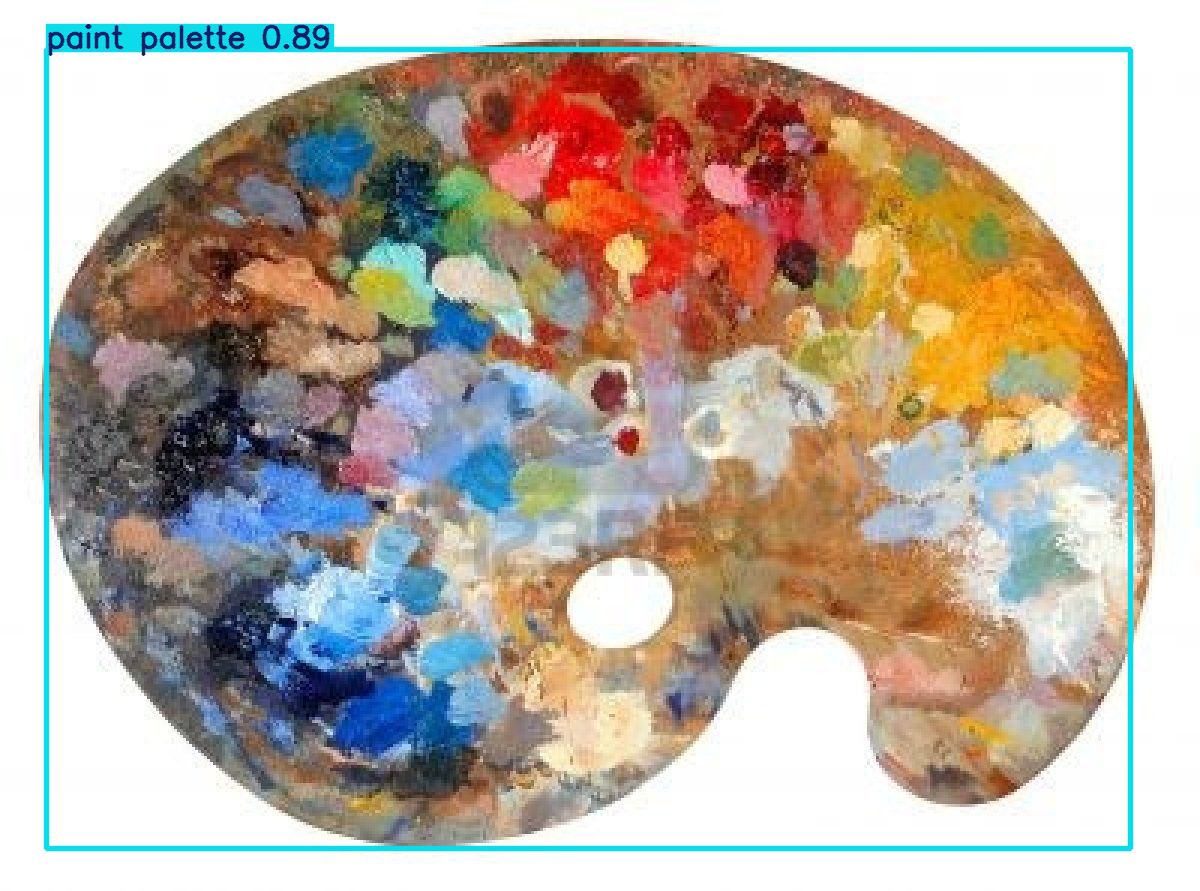

In [7]:
import ultralytics
from ultralytics import YOLO
from PIL import Image

source = "datasets/samples/oil_paint_palette_0020_dc232ff7cf86.jpg"
model = YOLO("assignment2_project/exp_c_sgd/weights/best_int8_openvino_model", task='detect')
result = model(source, conf=0.5, iou=0.6)

# Visualize the results
for i, r in enumerate(result):
    print(r)
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    r.show()

    # Save results to disk
    r.save(filename=f"results{i}.jpg")

Loading assignment2_project/exp_c_sgd/weights/best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference on CPU...

image 1/1 /content/datasets/samples/oil_paint_palette_0000_fe6cbee60be2.webp: 640x640 1 paint brush, 239.1ms
Speed: 5.4ms preprocess, 239.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'paint brush', 1: 'paint palette'}
obb: None
orig_img: array([[[224, 219, 229],
        [224, 219, 229],
        [224, 219, 229],
        ...,
        [226, 236, 253],
        [220, 233, 249],
        [216, 231, 247]],

       [[224, 219, 229],
        [224, 219, 229],
        [224, 219, 229],
        ...,
        [228, 239, 253],
        [223, 236, 250],
        [220, 234, 248]],

       [[226, 220, 230],
        [226, 220, 230],
        [226, 220, 230],
        ...,
        [228, 24

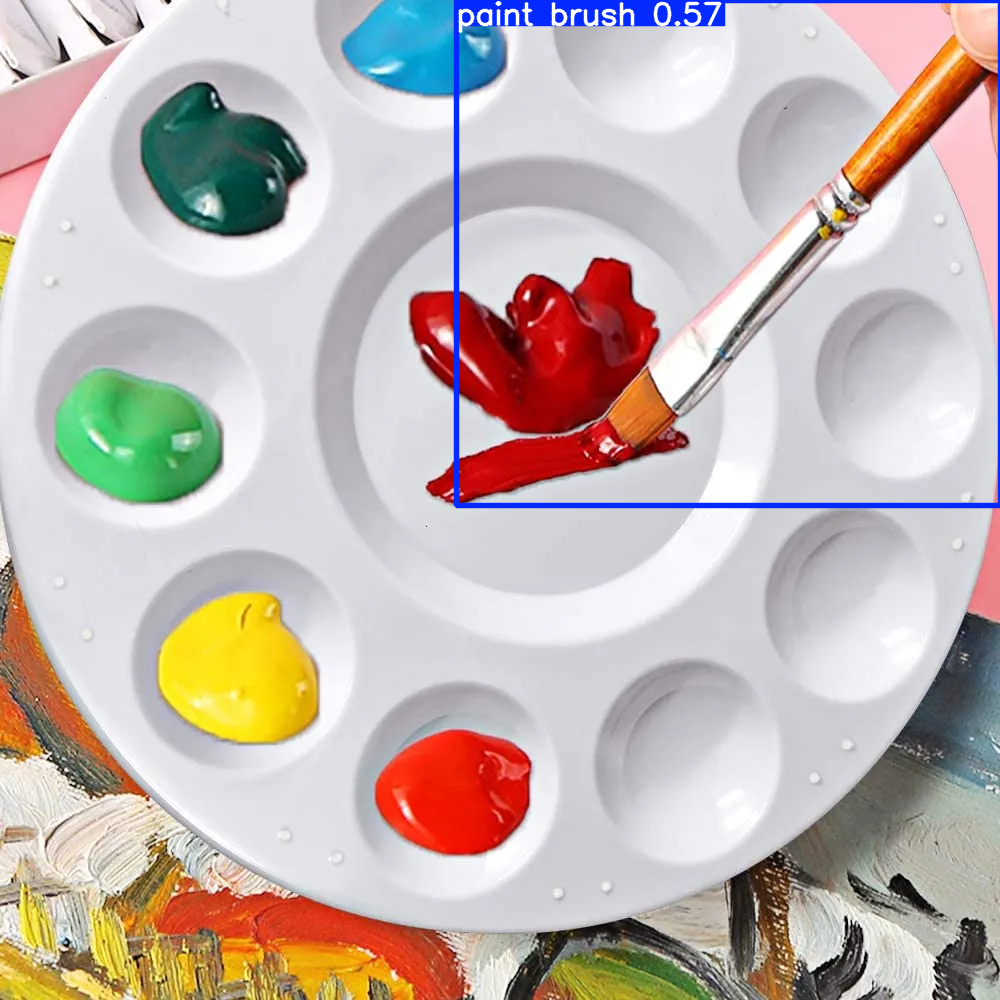

In [8]:
import ultralytics
from ultralytics import YOLO
from PIL import Image

source = "datasets/samples/oil_paint_palette_0000_fe6cbee60be2.webp"
model = YOLO("assignment2_project/exp_c_sgd/weights/best_int8_openvino_model", task='detect')
result = model(source, conf=0.5, iou=0.6)

# Visualize the results
for i, r in enumerate(result):
    print(r)
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    r.show()

    # Save results to disk
    r.save(filename=f"results{i}.jpg")

## Download the Model


In [11]:
%%bash
mv ./assignment2_project/exp_c_sgd/weights/best_int8_openvino_model/ .
zip -r assignment2_v1_openvino_model.zip best_int8_openvino_model

# Now go to best_openvino_model to download the best_openvino_model.zip file

updating: best_int8_openvino_model/ (stored 0%)
updating: best_int8_openvino_model/metadata.yaml (deflated 37%)
updating: best_int8_openvino_model/best.bin (deflated 17%)
updating: best_int8_openvino_model/best.xml (deflated 95%)


### Detect and write to a video file

In [14]:
from ultralytics import YOLO
import cv2
import os

# 1. Load the YOLO model
model = YOLO("best_int8_openvino_model", task="detect")

# 2. Open the video file
video_path = "datasets/paintbrush_video_v1.mp4"
output_path = "datasets/paintbrush_video_v1_output.mp4"
cap = cv2.VideoCapture(video_path)

# 3. Get video properties (width, height, fps) to create the writer
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# 4. Initialize the VideoWriter
# 'mp4v' is a standard codec for .mp4 files
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

print("Processing video... please wait.")

# 5. Loop through the video frames
while cap.isOpened():
    success, frame = cap.read()

    if success:
        # Run YOLO inference
        # Note: OpenVINO often runs faster on CPU
        results = model(frame, device="cpu")

        # Visualize the results
        annotated_frame = results[0].plot()

        # Write the frame to the video file instead of showing it
        out.write(annotated_frame)

    else:
        # Break the loop if the end of the video is reached
        break

# 6. Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"✅ Video processing complete! Saved to: {output_path}")

Streaming output truncated to the last 5000 lines.
Speed: 3.4ms preprocess, 148.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 149.2ms
Speed: 3.7ms preprocess, 149.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 150.7ms
Speed: 4.3ms preprocess, 150.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 145.3ms
Speed: 4.8ms preprocess, 145.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 147.7ms
Speed: 3.6ms preprocess, 147.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 164.9ms
Speed: 3.5ms preprocess, 164.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 145.6ms
Speed: 5.8ms preprocess, 145.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 149.3ms
Spee